<a href="https://www.kaggle.com/code/abhijitdarekar001/eda-birdclef24?scriptVersionId=170946358" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# BirdCLEF24 🐦‍⬛

The Goal of this Completations is to identify the Bird Calls in different soundscapes.


## Contents :



# 📂 Dataset Description

📁 test_soundscapes - The training data consists of short recordings of individual bird calls. These files have been downsampled to 32 kHz where applicable to match the test set audio and converted to the ogg format.
<br>📁 train_audio - The test_soundscapes directory will be populated with approximately 1,100 audio recordings to be used for scoring. They are 4 minutes long and in ogg audio format. 
<br>📁 unlabeled_soundscapes -  Unlabeled audio data from the same recording locations as the test soundscapes.
<br>📃 eBird_Taxonomy_v2021.csv - Meta Data Required for Training
<br>📃 train_metadata.csv - Required MetaData for Model Traning
<br>📃 sample_submission.csv - Format to Submit a File.
- `row_id` : A slug of `[soundscape_id]_[end_time]` for the prediction.
- `[bird_id]` : There are 182 bird ID columns. You will need to predict the probability of the presence of each bird for each row.


# 📚 Loading Libraries 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import plotly.express as px

import plotly

import librosa


from IPython.display import display, Audio , display_html
import warnings
warnings.filterwarnings("ignore")

import os

import gc
gc.collect()

30

In [3]:
class CFG:
    train_audio_files = '/kaggle/input/birdclef-2024/train_audio'
    test_audio_files = '/kaggle/input/birdclef-2024/test_soundscapes'
    unlabelled_audio_files = '/kaggle/input/birdclef-2024/unlabeled_soundscapes'
    
    train_meta_data = '/kaggle/input/birdclef-2024/train_metadata.csv'
    

# 📊 Loading Data


In [21]:
eBird  = pd.read_csv('/kaggle/input/birdclef-2024/eBird_Taxonomy_v2021.csv')
training_df = pd.read_csv("/kaggle/input/birdclef-2024/train_metadata.csv")

In [22]:
display(training_df.info())
display(training_df.head(5))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24459 entries, 0 to 24458
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     24459 non-null  object 
 1   secondary_labels  24459 non-null  object 
 2   type              24459 non-null  object 
 3   latitude          24081 non-null  float64
 4   longitude         24081 non-null  float64
 5   scientific_name   24459 non-null  object 
 6   common_name       24459 non-null  object 
 7   author            24459 non-null  object 
 8   license           24459 non-null  object 
 9   rating            24459 non-null  float64
 10  url               24459 non-null  object 
 11  filename          24459 non-null  object 
dtypes: float64(3), object(9)
memory usage: 2.2+ MB


None

primary_label secondary_labels      type  latitude  longitude  \
0        asbfly               []  ['call']   39.2297   118.1987   
1        asbfly               []  ['song']   51.4030   104.6401   
2        asbfly               []  ['song']   36.3319   127.3555   
3        asbfly               []  ['call']   21.1697    70.6005   
4        asbfly               []  ['call']   15.5442    73.7733   

      scientific_name             common_name  \
0  Muscicapa dauurica  Asian Brown Flycatcher   
1  Muscicapa dauurica  Asian Brown Flycatcher   
2  Muscicapa dauurica  Asian Brown Flycatcher   
3  Muscicapa dauurica  Asian Brown Flycatcher   
4  Muscicapa dauurica  Asian Brown Flycatcher   

                              author  \
0                     Matt Slaymaker   
1                   Magnus Hellström   
2                      Stuart Fisher   
3                          vir joshi   
4  Albert Lastukhin & Sergei Karpeev   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     5.0   
1  Creative Commons Attribution-NonCommercial-Sha...     2.5   
2  Creative Commons Attribution-NonCommercial-Sha...     2.5   
3  Creative Commons Attribution-NonCommercial-Sha...     4.0   
4  Creative Commons Attribution-NonCommercial-Sha...     4.0   

                                 url             filename  
0  https://www.xeno-canto.org/134896  asbfly/XC134896.ogg  
1  https://www.xeno-canto.org/164848  asbfly/XC164848.ogg  
2  https://www.xeno-canto.org/175797  asbfly/XC175797.ogg  
3  https://www.xeno-canto.org/207738  asbfly/XC207738.ogg  
4  https://www.xeno-canto.org/209218  asbfly/XC209218.ogg

Each row shows sicentific name , common_name and abbrivation for that bird, apart from this it also captures the author( The person who captured the recording) with respective location (long/lat). 

Each recording dispalys a unique call of the bird it can be `call`,`male`,`adult` or `fight call`.

#### Checking if any null values present in dataset.

In [23]:
training_df.isna().sum()

primary_label         0
secondary_labels      0
type                  0
latitude            378
longitude           378
scientific_name       0
common_name           0
author                0
license               0
rating                0
url                   0
filename              0
dtype: int64

The Features latiture and longitude have `378` null each.<br>
<b> Evan Features Secondry_Name has null in the form of `[]`, we need to convert them to `na`.

<b> For all the birds, we have respective calls `type`, `filename`.</b><br>
    
We will deal with them later.
    

### Exploring EBird Data

In [7]:
display_html("Information \n",raw=True)
display(eBird.info())
display_html("First Few Lines",raw=True)
display(eBird.head())
display_html("Displaying Null Values",raw =True)
display(eBird.isnull().sum())

Information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16753 entries, 0 to 16752
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   TAXON_ORDER       16753 non-null  int64 
 1   CATEGORY          16753 non-null  object
 2   SPECIES_CODE      16753 non-null  object
 3   PRIMARY_COM_NAME  16753 non-null  object
 4   SCI_NAME          16753 non-null  object
 5   ORDER1            16751 non-null  object
 6   FAMILY            16740 non-null  object
 7   SPECIES_GROUP     216 non-null    object
 8   REPORT_AS         3876 non-null   object
dtypes: int64(1), object(8)
memory usage: 1.2+ MB


None

First Few Lines

TAXON_ORDER CATEGORY SPECIES_CODE       PRIMARY_COM_NAME  \
0            1  species      ostric2         Common Ostrich   
1            6  species      ostric3         Somali Ostrich   
2            7    slash       y00934  Common/Somali Ostrich   
3            8  species      grerhe1           Greater Rhea   
4           14  species      lesrhe2            Lesser Rhea   

                         SCI_NAME            ORDER1  \
0                Struthio camelus  Struthioniformes   
1          Struthio molybdophanes  Struthioniformes   
2  Struthio camelus/molybdophanes  Struthioniformes   
3                  Rhea americana        Rheiformes   
4                    Rhea pennata        Rheiformes   

                      FAMILY SPECIES_GROUP REPORT_AS  
0  Struthionidae (Ostriches)     Ostriches       NaN  
1  Struthionidae (Ostriches)           NaN       NaN  
2  Struthionidae (Ostriches)           NaN       NaN  
3            Rheidae (Rheas)         Rheas       NaN  
4            Rheidae (Rheas)           NaN       NaN

Displaying Null Values

TAXON_ORDER             0
CATEGORY                0
SPECIES_CODE            0
PRIMARY_COM_NAME        0
SCI_NAME                0
ORDER1                  2
FAMILY                 13
SPECIES_GROUP       16537
REPORT_AS           12877
dtype: int64

There are total of `16537` entires in data. <br>
The features  `SPECIES_GROUP` and `REPORT_AS` are mostly `null`. Feature `FAMILY` and `ORDER1` have null in less numbers.

We will drop feature `SPECIES_GROUP` and `REPORT_AS`.

In [8]:
eBird.drop(['REPORT_AS','SPECIES_GROUP'],axis=1,inplace=True)

# 📈 Visulaization

In [24]:
px.bar(training_df.common_name.value_counts().reset_index(),y ='common_name',x='count',title='Count of Different Birds in Dataset.')

In [40]:
px.bar(eBird.FAMILY.value_counts().reset_index(),y='FAMILY',x='count',title = "Count of Bird's Family")

For visualization of features `longitudes` and `latitudes` we can  drop `nan` values. 

In [25]:
fig = px.scatter_geo(training_df[training_df['longitude'].notnull()],
                    lat='latitude',
                    lon='longitude',
                    title = "Location of Birds around the World",
                    color ="common_name",projection='hammer')

fig.show()

In [26]:
import plotly.graph_objs as go

data = [
    go.Pie(values=eBird.FAMILY.value_counts().reset_index()['count'],
        labels=eBird.FAMILY.value_counts().reset_index()['FAMILY'],
        domain={'x':[0.2,0.8], 'y':[0.1,0.9]},
        hole=0.5,
        direction='clockwise',
        sort=False,
        marker={'colors':['#CB4335','#2E86C1']}
          ),

    go.Pie(values=eBird.SCI_NAME.value_counts().reset_index()['count'],
        labels=eBird.SCI_NAME.value_counts().reset_index()['SCI_NAME'],
        domain={'x':[0.1,0.9], 'y':[0,1]},
        hole=0.75,
        direction='clockwise',
        sort=False,
        marker={'colors':['#EC7063','#F1948A','#5DADE2','#85C1E9']},
        showlegend=False
          )
]

fig = go.Figure(data=data, layout={'title':'Pie Chart Representing Birds and there respective class.','width':1500,'height':1000})
fig.update_traces(textinfo='none')
plotly.offline.iplot(fig)
gc.collect()

5709

In [39]:
# plt.hist(training_df.rating)
px.histogram(training_df,x = 'rating',title = 'Distribution of Rating of Audio Sample')

### Visualizing Audio files.

[]

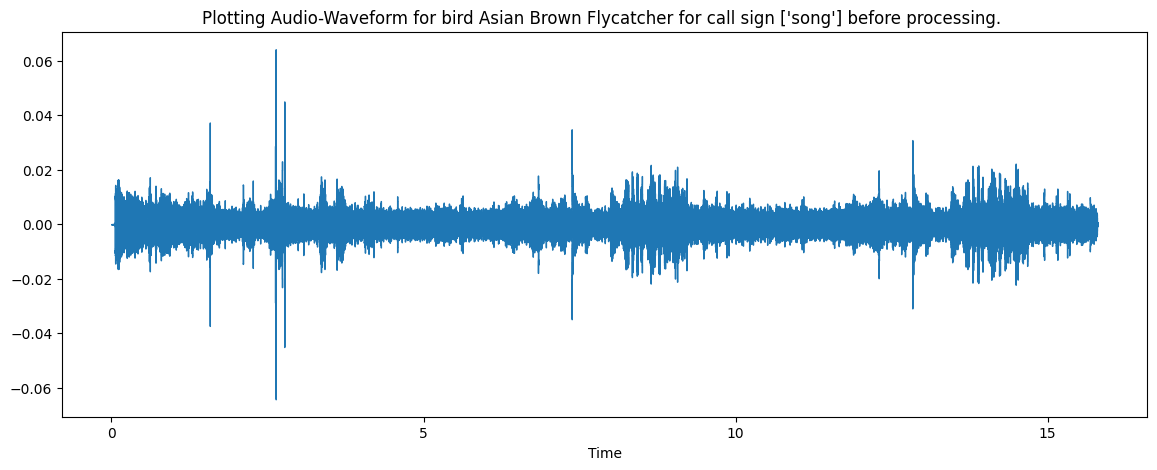

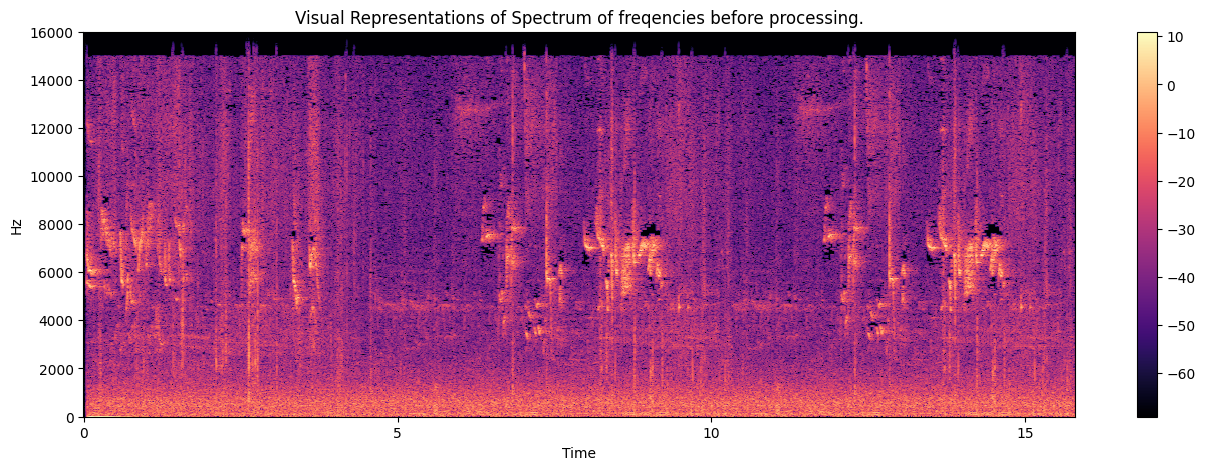

In [15]:
audio_path =  trainign_data.iloc[1]
x, sr = librosa.load(os.path.join(CFG.train_audio_files,audio_path['filename']),sr = 32000)
display(Audio(data = os.path.join(CFG.train_audio_files,audio_path['filename'])))
plt.figure(figsize=(14, 5))
plt.title(f"Plotting Audio-Waveform for bird {audio_path['common_name']} for call sign {audio_path['type']} before processing. ")
display(librosa.display.waveshow(x, sr=sr))
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(16, 5))
plt.title("Visual Representations of Spectrum of freqencies before processing.")
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
plt.colorbar()
plt.plot()

[]

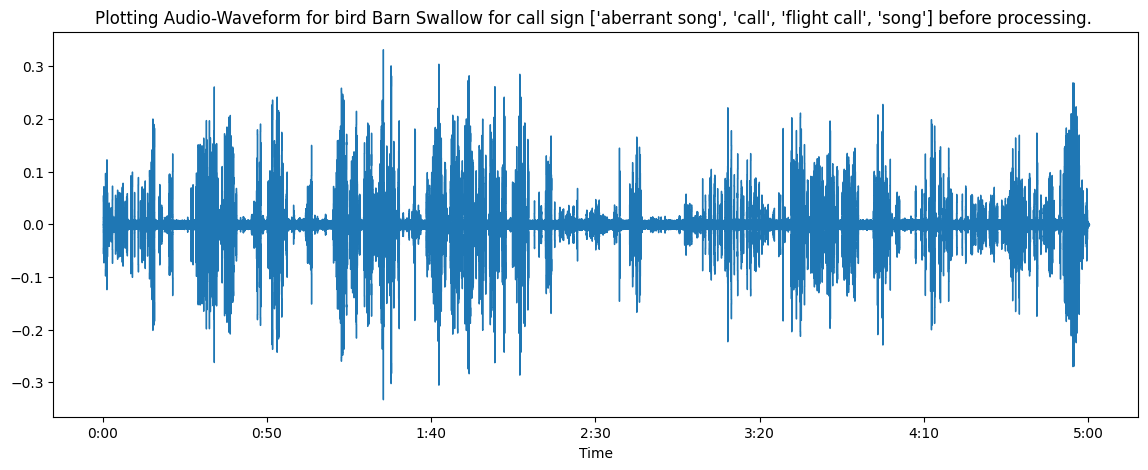

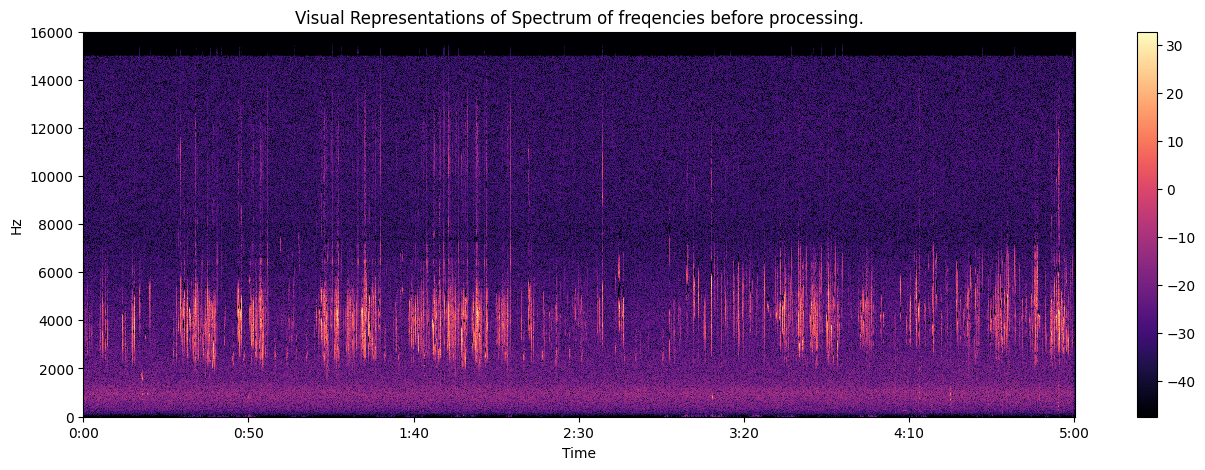

In [16]:
audio_path =  trainign_data.iloc[1000]
x, sr = librosa.load(os.path.join(CFG.train_audio_files,audio_path['filename']),sr = 32000)
display(Audio(data = os.path.join(CFG.train_audio_files,audio_path['filename'])))
plt.figure(figsize=(14, 5))
plt.title(f"Plotting Audio-Waveform for bird {audio_path['common_name']} for call sign {audio_path['type']} before processing. ")
display(librosa.display.waveshow(x, sr=sr))
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(16, 5))
plt.title("Visual Representations of Spectrum of freqencies before processing.")
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
plt.colorbar()
plt.plot()

Looking at both the signal waves, you can see that , first wave has small difference between the background music and some sound events, where as second sound has higher differece in background noise and sound events.

# Thank you